In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

In [2]:
delta_W1 = []           
delta_T1 = []  
delta_W2 = []           
delta_T2 = []  
def pairbasedSTDP(I_init, gl, Cm, num, T1 , T2, T3 ):
    U_rest = -0.065                  
    U_reset = -0.065
    thresh = -0.050                       
    tau = Cm/gl                            
    A_plus = 2                             
    A_neg = -2
    tau_t = 0.005    

    T = 0.100                      
    dt = 0.00002                      
    time = np.arange(0, T+dt, dt)      
    
    U_Pre1 = np.empty(len(time))   
    U_Post1 = np.empty(len(time))
    U_Pre2 = np.empty(len(time))   
    U_Post2 = np.empty(len(time))
    
    U_Pre1[0] = U_rest               
    U_Post1[0] = U_rest
    U_Pre2[0] = U_rest               
    U_Post2[0] = U_rest
    
    I_init = I_initial(I_init=I_init, time=time,num = num)
    I = np.zeros((3,len(time)))
      
    spikes_Pre1 = [0]          
    spikes_Post1 = [0]
    spikes_Pre2 = [0]          
    spikes_Post2 = [0]
    
    W1 = weights()  
    W2 = weights()
    
    cnt1=0
    cnt2=0
     
    for i in range(len(time)-4):
            I[0,i]= I_init[i]*bool(i > T1) + I[0,i]
            I[1,i]= I_init[i]*bool(i > T2) + I[1,i]
            I[2,i]= I_init[i]*bool(i > T3) + I[2,i]
            U_Pre1[i] = (((U_rest - U_Pre1[i-1]) + I[0][i]/gl)*dt)/tau + U_Pre1[i-1]
            U_Post1[i] = (((U_rest - U_Post1[i-1]) + I[1][i]/gl)*dt)/tau + U_Post1[i-1]
            U_Pre2[i] = (((U_rest - U_Pre2[i-1]) + I[1][i]/gl)*dt)/tau + U_Pre2[i-1]
            U_Post2[i] = (((U_rest - U_Post2[i-1]) + I[2][i]/gl)*dt)/tau + U_Post2[i-1]
            
                 
            if U_Post1[i] > thresh:
                U_Post1[i-1] = 0.04           
                U_Post1[i] = U_reset          
                spikes_Post1.append(time[i])  
                delta_T1.append((spikes_Post1[-1] - spikes_Pre1[-1]))
                delta_W1.append((A_plus*math.exp(-1*abs(delta_T1[-1])/tau_t)))
                W1[0][1] += delta_W1[-1]
                cnt1+=1
                add_amount = I_values(1,i,I_init,time,spikes_Pre1,W1)
                I[0:2,i+1:i+5] = I[0:2,i+1:i+5] + add_amount
                
            if U_Post2[i] > thresh:
                U_Post2[i-1] = 0.04           
                U_Post2[i] = U_reset          
                spikes_Post2.append(time[i])  
                delta_T2.append((spikes_Post2[-1] - spikes_Pre2[-1]))
                delta_W2.append((A_plus*math.exp(-1*abs(delta_T2[-1])/tau_t)))
                W2[0][1] += delta_W2[-1]
                cnt2+=1
                add_amount = I_values(1,i,I_init,time,spikes_Pre2,W2)
                I[1:3,i+1:i+5] = I[1:3,i+1:i+5] + add_amount
                
            if U_Pre1[i] > thresh:
                U_Pre1[i-1] = 0.04          
                U_Pre1[i] = U_reset          
                spikes_Pre1.append(time[i]) 
                delta_T1.append((spikes_Post1[-1] - spikes_Pre1[-1]))
                delta_W1.append((A_neg*math.exp(-1*abs(delta_T1[-1])/tau_t)))
                W1[1][0] += delta_W1[-1]
                cnt2+=1
                add_amount = I_values(0,i,I_init,time,spikes_Post1,W1)
                I[0:2,i+1:i+5] = I[0:2,i+1:i+5] + add_amount
            
            if U_Pre2[i] > thresh:
                U_Pre2[i-1] = 0.04          
                U_Pre2[i] = U_reset          
                spikes_Pre2.append(time[i]) 
                delta_T2.append((spikes_Post2[-1] - spikes_Pre2[-1]))
                delta_W2.append((A_neg*math.exp(-1*abs(delta_T2[-1])/tau_t)))
                W2[1][0] += delta_W2[-1]
                cnt2+=1
                add_amount = I_values(0,i,I_init,time,spikes_Post2,W2)
                I[1:3,i+1:i+5] = I[1:3,i+1:i+5] + add_amount
                
    return delta_W1, delta_T1, spikes_Pre1, spikes_Post1, cnt1, delta_W2, delta_T2, spikes_Pre2, spikes_Post2, cnt2


In [3]:
def I_initial(I_init=0.005, time=None, num = 1):
    I0 = np.zeros(len(time))
    I0[0:4999] = I_init
    I1 = []
    I2 = []
    I3 = []
    #I1 
    for i in range(0, len(time)):
        var = gauss(I_init,I_init*0.1)
        I1.append(var) 
    #I2
    for i in range(0, len(time)):
        var = ((math.cos(i/100)+1)/4)*((math.sin(i/300)+1)/4)*(gauss(0,0.4*I_init))+I_init
        I2.append(var)
    #I3
    for i in range(0, len(time)):
        var = ((math.sin(i/100)+1)/4)*((math.cos(i/300)+1)/4)*(gauss(0,0.4*I_init))+I_init
        I3.append(var)
    I = [I0,I1,I2,I3]
    return I[num-1]
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, W=None ,tau_I=0.001):
    exp1= (time[i+1:i+5] - spikes[-1])/tau_I
    exp2= np.exp(1-exp1)
    exp3= exp1*exp2
    I_inp = np.dot(W[j,:].reshape(2,1),exp3.reshape(1,4))
    return I_inp
def weights():
    w = np.zeros((2,2))
    w[:,:] = abs(np.random.normal(6,4,size=(2,2)))/10
    for i in range(2): w[i,i]=0
    return w

In [4]:
def simul_STDP(I_init ,gl_init ,Cm_init, num , time1, time2 , time3):
    delta_W1, delta_T1, spike_Pre1, spike_Post1, cnt1,delta_W2, delta_T2, spike_Pre2, spike_Post2, cnt2= pairbasedSTDP(I_init, gl_init, Cm_init, num, time1, time2 ,time3)
    delta_W1 = np.array(delta_W1)
    delta_T1 = np.array(delta_T1) 
    delta_W2 = np.array(delta_W2)
    delta_T2 = np.array(delta_T2) 
    event1 = [spike_Pre1,spike_Post1]
    event2 = [spike_Pre2,spike_Post2]
    zero_t1 = np.zeros(len(delta_T1))
    zero_w1 = np.zeros(len(delta_W1))
    zero_t2 = np.zeros(len(delta_T2))
    zero_w2 = np.zeros(len(delta_W2))
    final1 = len(delta_W1)
    final2 = len(delta_W2)

    axis_color = 'lightgoldenrodyellow'
    fig1 = plt.figure("current1", figsize=(12, 4))
    plt.title("spike raster plot")
    plt.eventplot(event1 , color = [[0, 0, 1],[1, 0, 1]])
    plt.ylabel("Neuron")
    plt.xlabel("Spike - Time [s]")
    fig1 = plt.figure("Population activity of neurons1", figsize=(12, 8))
    plt.title("∆t = t-post − t-pre")
    plt.scatter(delta_T1[-cnt1:final1],delta_W1[-cnt1:final1], marker='o', s=10, c='blue',label="new results")
    plt.scatter(delta_T1[0:-cnt1],delta_W1[0:-cnt1], marker='o', s=10, c='magenta',label="old results")
    plt.plot(delta_T1,zero_t1,':r')
    plt.plot(zero_w1,delta_W1,':r')
    plt.ylabel("∆w")
    plt.xlabel("Time-difference [s]")
    plt.legend()
    
    axis_color = 'lightgoldenrodyellow'
    fig2 = plt.figure("current2", figsize=(12, 4))
    plt.title("spike raster plot")
    plt.eventplot(event2 , color = [[0, 0, 1],[1, 0, 1]])
    plt.ylabel("Neuron")
    plt.xlabel("Spike - Time [s]")
    fig2 = plt.figure("Population activity of neurons2", figsize=(12, 8))
    plt.title("∆t = t-post − t-pre")
    plt.scatter(delta_T2[-cnt2:final2],delta_W2[-cnt2:final2], marker='o', s=10, c='blue',label="new results")
    plt.scatter(delta_T2[0:-cnt2],delta_W2[0:-cnt2], marker='o', s=10, c='magenta',label="old results")
    plt.plot(delta_T2,zero_t2,':r')
    plt.plot(zero_w2,delta_W2,':r')
    plt.ylabel("∆w")
    plt.xlabel("Time-difference [s]")
    plt.legend()

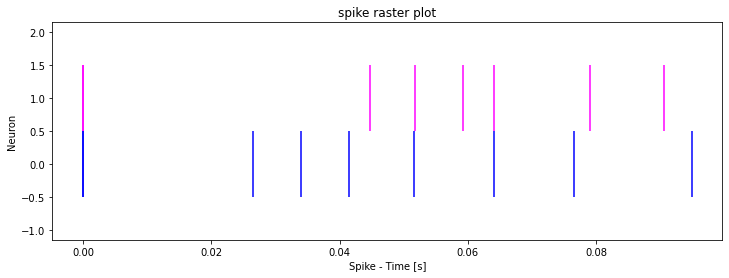

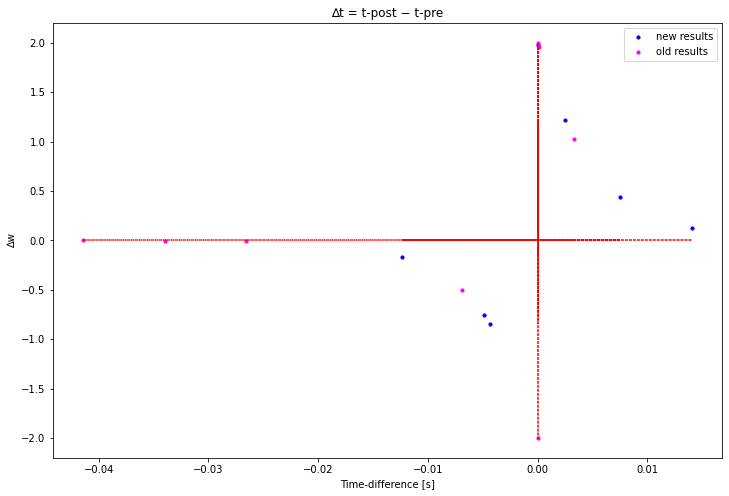

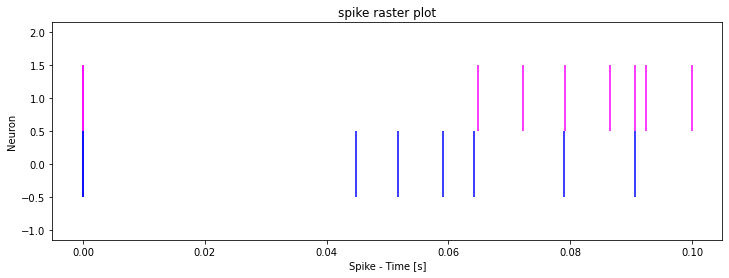

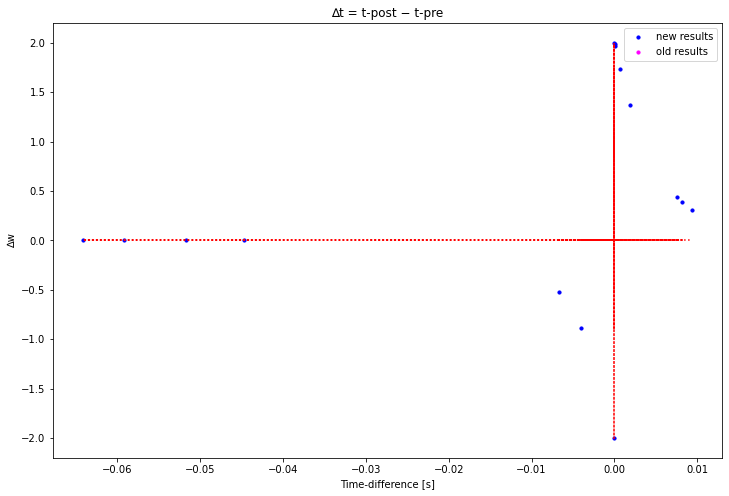

In [5]:
simul_STDP(0.01 ,0.016,0.0049 ,3 , 1000, 2000, 3000)

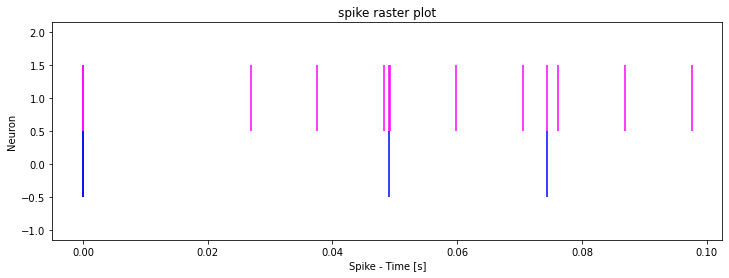

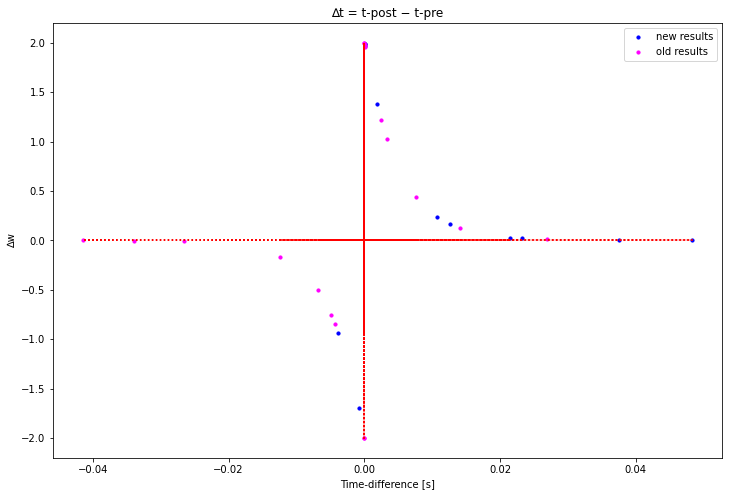

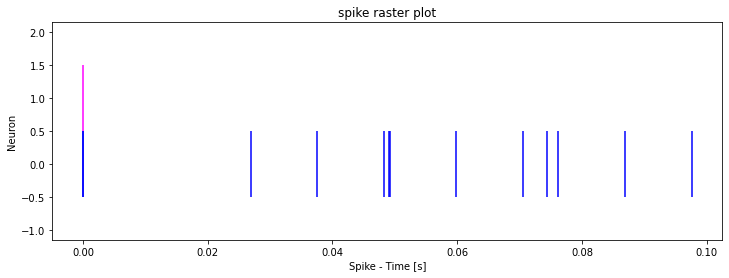

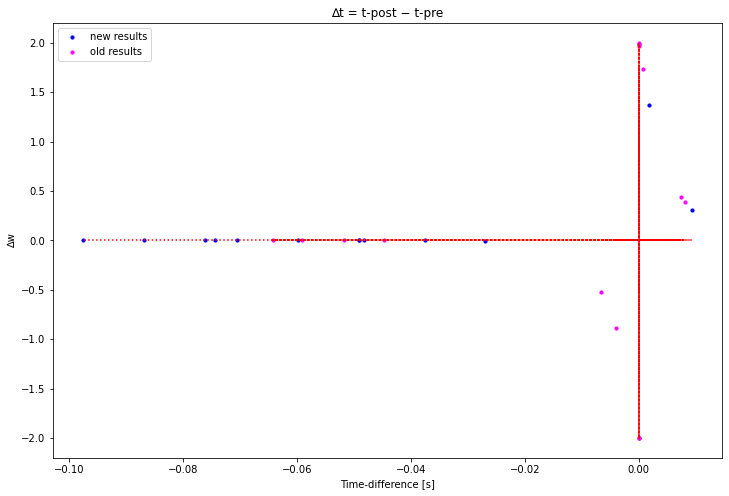

In [6]:
simul_STDP(0.007 ,0.016,0.0049 ,3 , 2000 , 1000, 3000)